# Make plots for the brown bag

In [1]:
%matplotlib inline
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Tuple, Sequence, Callable, Union, Optional
from tqdm.notebook import tqdm
from mpl_toolkits import axes_grid1

from sklearn import metrics
from scipy.special import erf

from bioslds.regressors import (
    BioWTARegressor,
    CrosscorrelationRegressor,
    CepstralRegressor,
    VarianceRegressor,
)
from bioslds.plotting import FigureManager, show_latent, colorbar, make_gradient_cmap
from bioslds.cluster_quality import calculate_sliding_score, unordered_accuracy_score
from bioslds.dataset import RandomArmaDataset, SwitchingSignal
from bioslds.batch import hyper_score_ar
from bioslds.arma import make_random_arma, Arma
from bioslds.regressor_utils import to_hankel, transform_ar
from bioslds.monitor import AttributeMonitor
from bioslds import sources
from bioslds.arma_hsmm import sample_switching_models
from bioslds.utils import rle_encode

In [2]:
fig_path = os.path.join("..", "figs")

## Useful definitions

### General

In [3]:
def predict_accuracy(armas: tuple, sig: SwitchingSignal) -> float:
    """ Predict accuracy score from ARMA models.
    
    Parameters
    ----------
    armas
        Pair of `Arma` models.
    sig
        Signal generated from the ARMA models.
    
    Returns a predicted value for the expected accuracy score of a
    winner-take-all method.
    """
    a1 = armas[0].a
    a2 = armas[1].a

    diff = a2 - a1

    p = len(a1)
    x = to_hankel(sig.y, p)[p - 1 : -1]
    s = np.dot(diff, x.T)
    prob_seq = 0.5 * (1 + erf(np.abs(s) / np.sqrt(8)))
    
    return np.mean(prob_seq)

## Sketch how mis-identified samples occur

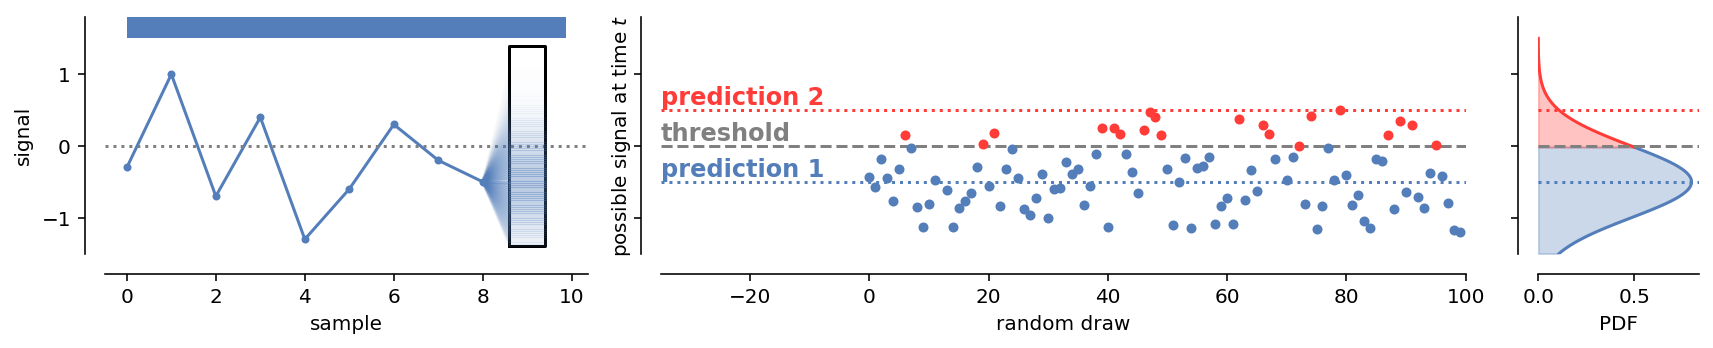

In [4]:
with FigureManager(
    1, 3, gridspec_kw={"width_ratios": (3, 5, 1)}, sharey=True, figsize=(12, 2.5)
) as (
    fig,
    (ax0, ax1, ax2),
):
    crt_sigma = 0.5
    crt_pred1 = -crt_sigma
    crt_pred2 = crt_sigma

    crt_thresh = 0.5 * (crt_pred1 + crt_pred2)
    
    crt_samples = [-0.3, 1.0, -0.7, 0.4, -1.3, -0.6, 0.3, -0.2, -0.5]
    crt_n = len(crt_samples)
    crt_usage = np.zeros(crt_n + 1, dtype=int)
    ax0.plot(crt_samples, ".-", c="C0")
    ax0.axhline(0, ls=":", c="gray")

    crt_box = [[crt_n - 0.4, crt_n + 0.4], [-1.4, 1.4]]
    ax0.plot(
        crt_box[0] + crt_box[0][::-1] + [crt_box[0][0]],
        [crt_box[1][0]] + crt_box[1] + crt_box[1][::-1],
        "k-",
    )

    crt_p_range = (-1.5, 1.5)
    ax0.set_ylim(*crt_p_range)
    ax0.set_xlabel("sample")
    ax0.set_ylabel("signal")

    show_latent(crt_usage, ax=ax0)

    crt_ps = np.linspace(*crt_p_range, 100)
    crt_dist = (
        1
        / np.sqrt(2 * np.pi * crt_sigma ** 2)
        * np.exp(-0.5 * ((crt_ps - crt_pred1) / crt_sigma) ** 2)
    )
    for crt_y, crt_p in zip(crt_ps, crt_dist):
        if crt_y < crt_box[1][0] or crt_y >= crt_box[1][1]:
            continue
        ax0.plot(
            [crt_n - 1, crt_box[0][0]],
            [crt_samples[-1], crt_y],
            c="C0",
            alpha=0.5 * crt_p,
        )
        ax0.plot(
            [crt_box[0][0] + 0.01, crt_box[0][1] - 0.01],
            [crt_y, crt_y],
            c="C0",
            alpha=0.5 * crt_p,
        )

    crt_col1 = "C0"
    crt_col2 = "C1"
    crt_col_err1 = "C1"
    crt_col_err2 = "C4"

    ax1.axhline(crt_pred1, c=crt_col1, ls=":")
    ax1.axhline(crt_pred2, c=crt_col2, ls=":")
    ax1.axhline(crt_thresh, c="gray", ls="--")

    rng = np.random.default_rng(0)
    crt_n = 100
    crt_samples1 = rng.normal(crt_pred1, crt_sigma, size=crt_n)
    # crt_samples2 = rng.normal(crt_pred2, crt_sigma, size=crt_n)

    crt_correct1 = crt_samples1 < crt_thresh
    crt_idxs = np.arange(crt_n)
    crt_ms = 8
    ax1.plot(
        crt_idxs[crt_correct1], crt_samples1[crt_correct1], ".", c=crt_col1, ms=crt_ms
    )
    ax1.plot(
        crt_idxs[~crt_correct1],
        crt_samples1[~crt_correct1],
        ".",
        c=crt_col_err1,
        ms=crt_ms,
    )

    # crt_correct2 = crt_samples2 >= crt_thresh
    # ax1.plot(crt_idxs[crt_correct2], crt_samples2[crt_correct2], ".", c=crt_col2)
    # ax1.plot(crt_idxs[~crt_correct2], crt_samples2[~crt_correct2], ".", c=crt_col_err2)

    crt_x0 = -35
    ax1.set_xlim(crt_x0, crt_n)

    ax1.annotate(
        "prediction 1",
        xy=(crt_x0, crt_pred1),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color=crt_col1,
    )
    ax1.annotate(
        "prediction 2",
        xy=(crt_x0, crt_pred2),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color=crt_col2,
    )
    ax1.annotate(
        "threshold",
        xy=(crt_x0, crt_thresh),
        verticalalignment="bottom",
        fontweight="bold",
        fontsize=12,
        color="gray",
    )

    ax1.set_xlabel("random draw")
    ax1.set_ylabel("possible signal at time $t$")

    crt_cut_idx = np.argmin(np.abs(crt_ps - crt_thresh))
    ax2.plot(crt_dist[: crt_cut_idx + 1], crt_ps[: crt_cut_idx + 1], c=crt_col1)
    ax2.plot(crt_dist[crt_cut_idx:], crt_ps[crt_cut_idx:], c=crt_col_err1)

    ax2.fill_betweenx(
        crt_ps[: crt_cut_idx + 1],
        crt_dist[: crt_cut_idx + 1],
        color=crt_col1,
        alpha=0.3,
    )
    ax2.fill_betweenx(
        crt_ps[crt_cut_idx:], crt_dist[crt_cut_idx:], color=crt_col_err1, alpha=0.3,
    )

    ax2.axhline(crt_pred1, c=crt_col1, ls=":")
    ax2.axhline(crt_pred2, c=crt_col2, ls=":")
    ax2.axhline(crt_thresh, c="gray", ls="--")

    ax2.set_xlim(0, None)

    ax2.set_xlabel("PDF")

# fig.savefig(
#     os.path.join(fig_path, "explanation_for_segmentation_errors.pdf"), transparent=True
# )

## Test run on a random dataset -- two alternating AR(3) processes

Winner-take-all algorithm *without* custom `trans_mat` here!

In [5]:
two_ar3 = SimpleNamespace(
    n_signals=100,
    n_samples=200_000,
    metric=unordered_accuracy_score,
    orders=[(3, 0), (3, 0)],
    dwell_times=100,
    min_dwell=50,
    n_models=2,
    n_features=3,
    rate_biowta=7e-4,
    streak_biowta=2.5,
    rate_nsm=4.0e-3,
    streak_nsm=6.0,
    rate_cepstral=0.16,
    rate_avg_error=0.16,
    # fix_scale=1.0,
    fix_scale=None,
    seed=153,
    # max_pole_radius=0.9,
    max_pole_radius=1.0,
)
two_ar3.dataset = RandomArmaDataset(
    two_ar3.n_signals,
    two_ar3.n_samples,
    two_ar3.orders,
    dwell_times=two_ar3.dwell_times,
    min_dwell=two_ar3.min_dwell,
    fix_scale=two_ar3.fix_scale,
    rng=two_ar3.seed,
    arma_kws={"max_pole_radius": two_ar3.max_pole_radius},
)

In [6]:
t0 = time.time()
two_ar3.result_biowta = hyper_score_ar(
    BioWTARegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    rate=two_ar3.rate_biowta,
    # trans_mat=1 - 1 / two_ar3.streak_biowta,
    progress=tqdm,
    monitor=["r", "weights_", "prediction_"],
)
t1 = time.time()
print(
    f"Median accuracy score BioWTA: {two_ar3.result_biowta[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score BioWTA: 0.72. (Took 55.97 seconds.)


In [7]:
t0 = time.time()
two_ar3.result_xcorr = hyper_score_ar(
    CrosscorrelationRegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    nsm_rate=two_ar3.rate_nsm,
    xcorr_rate=1 / two_ar3.streak_nsm,
    progress=tqdm,
    monitor=["r", "nsm.weights_", "xcorr.coef_"],
)
t1 = time.time()
print(
    f"Median accuracy score xcorr: {two_ar3.result_xcorr[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score xcorr: 0.79. (Took 91.65 seconds.)


In [8]:
two_ar3.rolling_score_biowta = []
two_ar3.rolling_score_xcorr = []
for i in tqdm(range(two_ar3.n_signals)):
    crt_dataset = two_ar3.dataset[i]

    crt_r_biowta = two_ar3.result_biowta[1].history[i].r
    crt_inferred_biowta = np.argmax(crt_r_biowta, axis=1)

    crt_loc_biowta, crt_sliding_score_biowta = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_biowta
    )
    two_ar3.rolling_score_biowta.append((crt_loc_biowta, crt_sliding_score_biowta))

    crt_r_xcorr = two_ar3.result_xcorr[1].history[i].r
    crt_inferred_xcorr = np.argmax(crt_r_xcorr, axis=1)

    crt_loc_xcorr, crt_sliding_score_xcorr = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_xcorr
    )
    two_ar3.rolling_score_xcorr.append((crt_loc_xcorr, crt_sliding_score_xcorr))

### Plots for BioWTA results

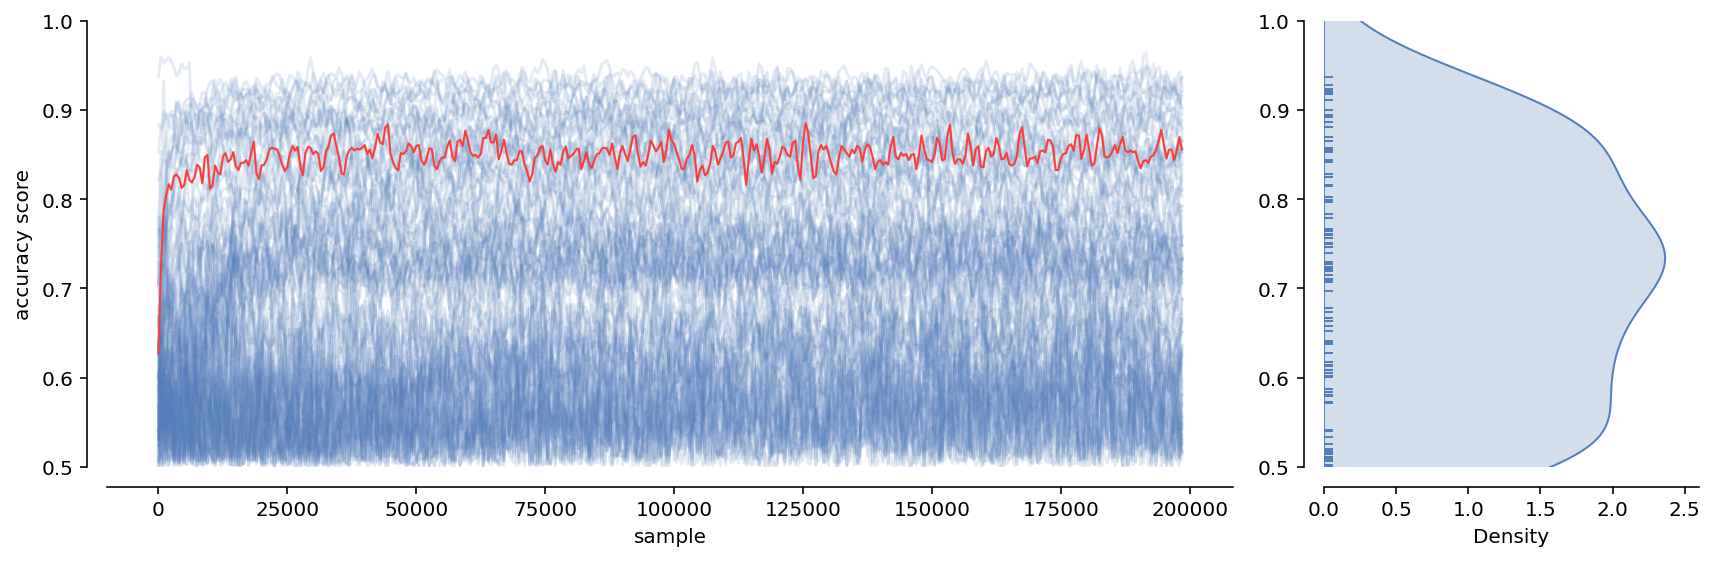

In [9]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_biowta:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    idx = np.argmin(np.abs(two_ar3.result_biowta[1].trial_scores - 0.85))
    ax1.plot(*two_ar3.rolling_score_biowta[idx], c="C1", lw=1)
    
    ax1.set_ylim(0.5, 1.0)
    
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        y=two_ar3.result_biowta[1].trial_scores, shade=True, ax=ax2
    )
    sns.rugplot(y=two_ar3.result_biowta[1].trial_scores, ax=ax2)
    ax2.set_ylim(0.5, 1.0)

# fig.savefig(os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials.png"), dpi=300)

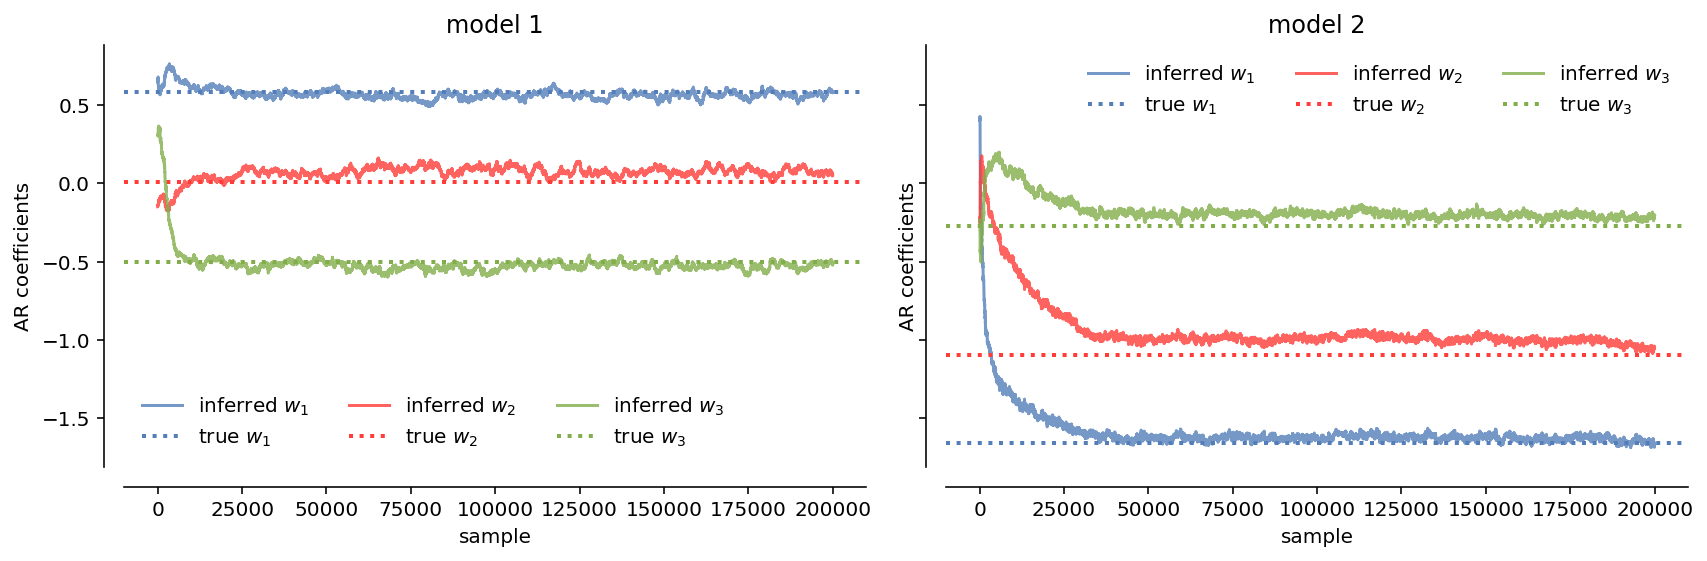

In [10]:
with FigureManager(1, two_ar3.n_models, sharey=True) as (fig, axs):
    crt_weights = two_ar3.result_biowta[1].history[idx].weights_
    for i, ax in enumerate(axs):
        crt_true = two_ar3.dataset.armas[idx][i].a
        for k in range(len(crt_true)):
            ax.plot(
                crt_weights[:, i, k], f"C{k}", alpha=0.80, label=f"inferred $w_{k + 1}$"
            )
            ax.axhline(crt_true[k], c=f"C{k}", ls=":", lw=2, label=f"true $w_{k + 1}$")

        ax.set_xlabel("sample")
        ax.set_ylabel("AR coefficients")

        ax.legend(ncol=3, frameon=False)
        ax.set_title(f"model {i + 1}")

# fig.savefig(
#     os.path.join(fig_path, "example_2x_ar3_model_learning.png"),
#     transparent=True,
#     dpi=300,
# )

Accuracy score in this interval: 0.88.


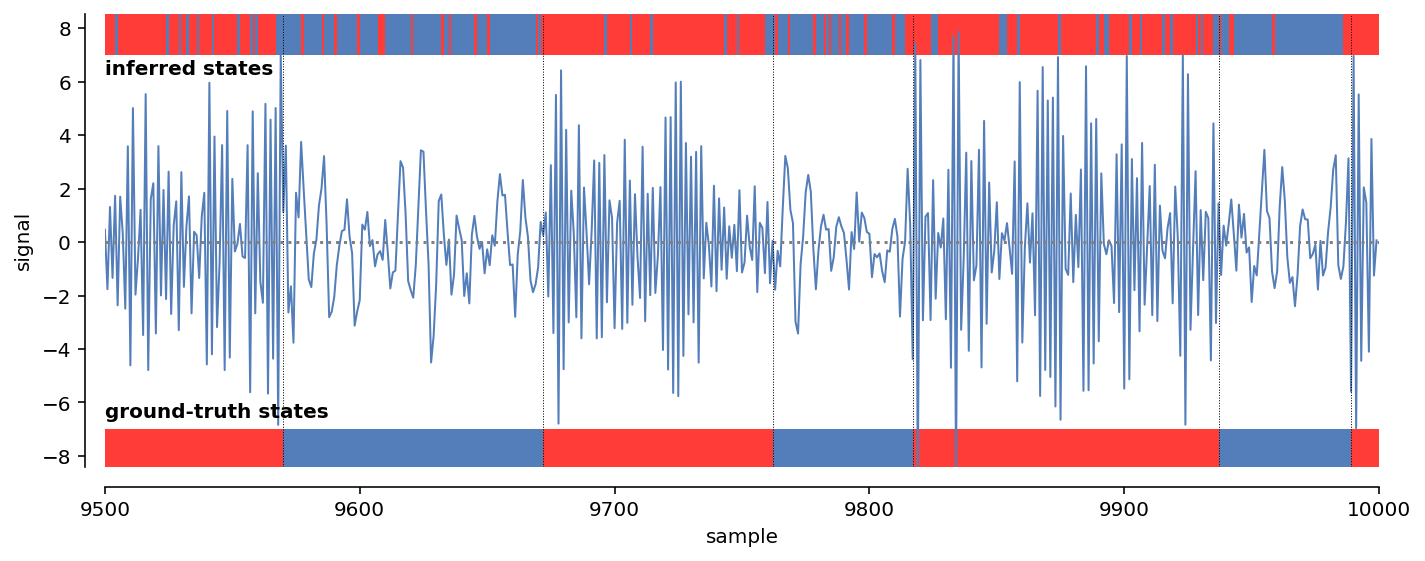

In [11]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

# fig.savefig(os.path.join(fig_path, "example_2x_ar3_short.pdf"))

Accuracy score in this interval: 0.88.


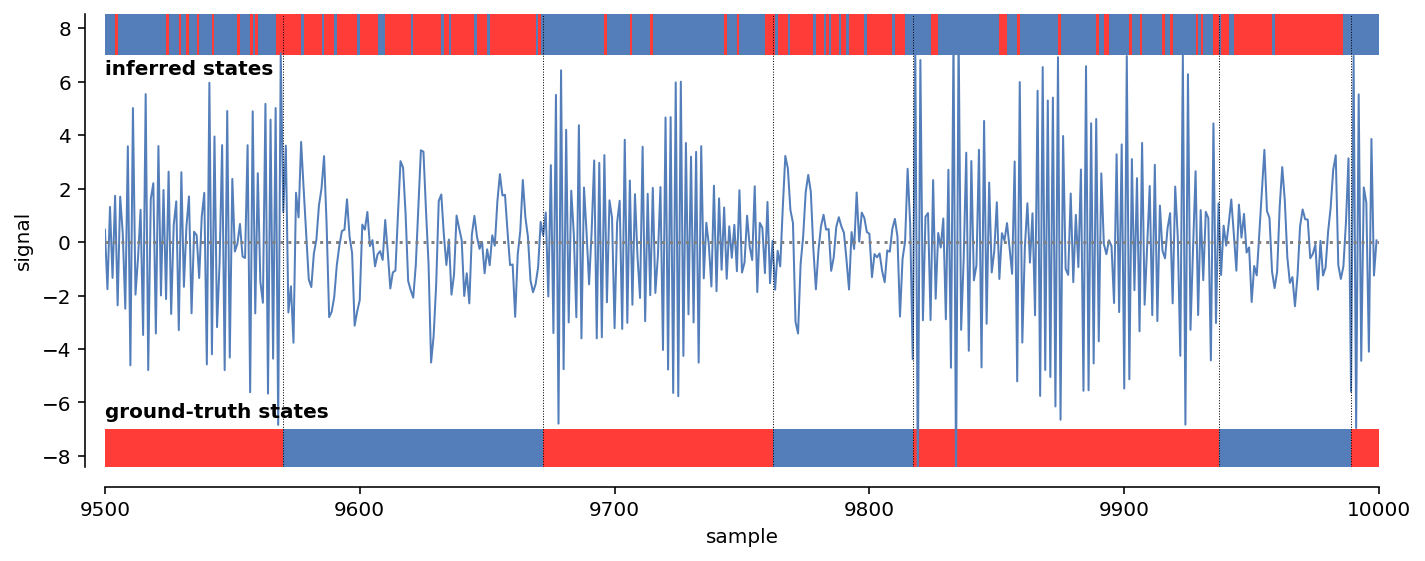

In [12]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[idx]
    show_latent(1 - np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

# fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_flipped.pdf"))

Attempt to predict segmentation accuracy.

In [13]:
two_ar3.diff_arma = [
    np.linalg.norm(crt_armas[0].a - crt_armas[1].a)
    for crt_armas in two_ar3.dataset.armas
]
two_ar3.predicted_score = [
    predict_accuracy(crt_armas, crt_sig)
    for crt_armas, crt_sig in zip(tqdm(two_ar3.dataset.armas), two_ar3.dataset)
]

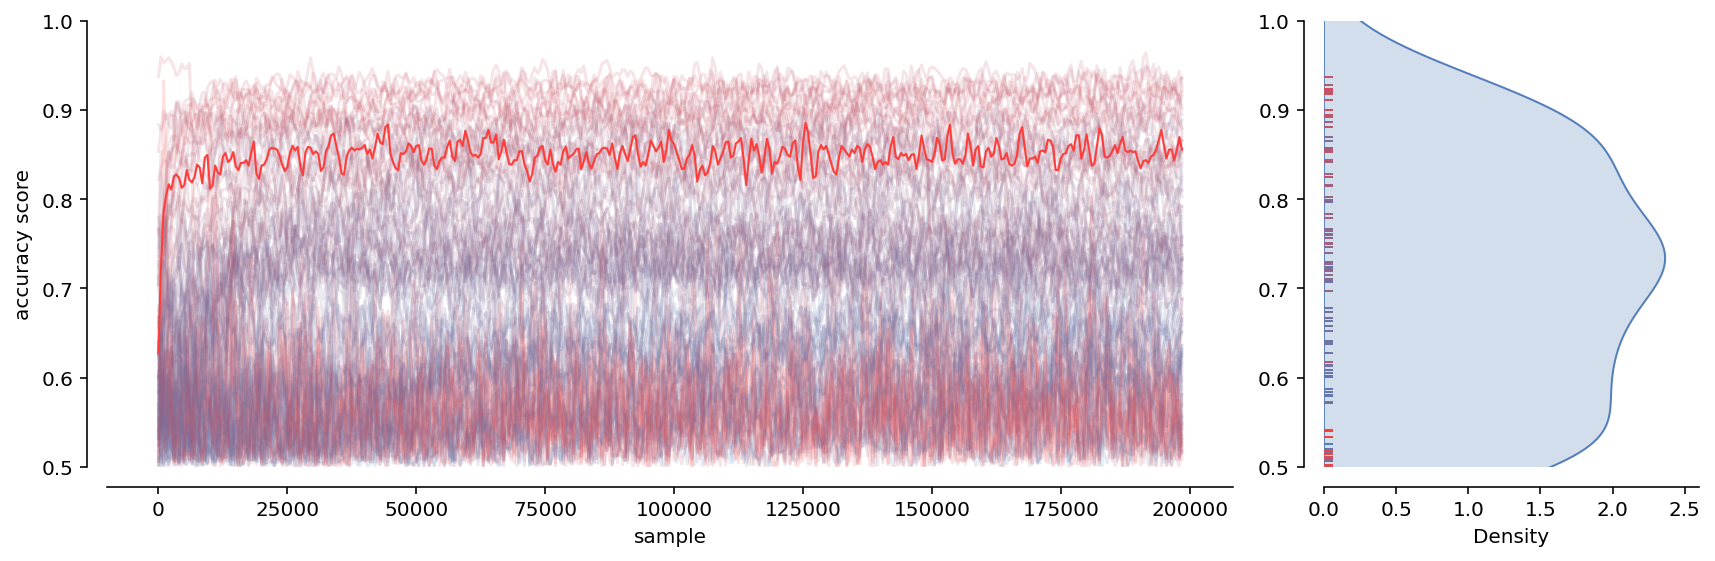

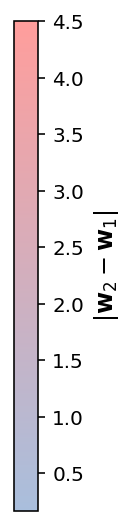

In [14]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    crt_cmap = make_gradient_cmap("C0_to_C1", "C0", "C1")
    crt_min = np.min(two_ar3.diff_arma)
    crt_max = np.max(two_ar3.diff_arma)
    crt_range = crt_max - crt_min
    for i, crt_rolling in enumerate(two_ar3.rolling_score_biowta):
        crt_score = two_ar3.diff_arma[i]
        ax1.plot(
            *crt_rolling, c=crt_cmap((crt_score - crt_min) / crt_range), alpha=0.15
        )

    ax1.plot(*two_ar3.rolling_score_biowta[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(y=two_ar3.result_biowta[1].trial_scores, shade=True, ax=ax2)
    sns.rugplot(
        y=two_ar3.result_biowta[1].trial_scores,
        hue=(two_ar3.diff_arma - crt_min) / crt_range,
        palette=crt_cmap,
        legend=False,
        # colors=crt_cmap((two_ar3.diff_arma - crt_min) / crt_range),
        ax=ax2,
    )
    ax2.set_ylim(0.5, 1.0)

# fig.savefig(
#     os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_color_by_armadiff.png"),
#     dpi=300,
# )

with FigureManager(figsize=(1.75, 3.75)) as (fig, ax):
    divider = axes_grid1.make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="25%", pad=0.05)
    crt_alpha = 0.5
    crt_rgb1 = np.asarray(mpl.colors.to_rgb("C0")) * crt_alpha + (1 - crt_alpha)
    crt_rgb2 = np.asarray(mpl.colors.to_rgb("C1")) * crt_alpha + (1 - crt_alpha)
    crt_cmap_light = make_gradient_cmap("C0_to_C1_light", crt_rgb1, crt_rgb2)
    cbar = mpl.colorbar.ColorbarBase(
        ax_cb,
        cmap=crt_cmap_light,
        orientation="vertical",
        norm=mpl.colors.Normalize(vmin=crt_min, vmax=crt_max),
    )
    cbar.set_label("$|{\\bf w}_2 - {\\bf w}_1|$", fontsize=12)
    fig.add_axes(ax_cb)

    ax.set_visible(False)

# fig.savefig(
#     os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_armadiff_colorbar.png"),
#     transparent=True,
#     dpi=300,
# )

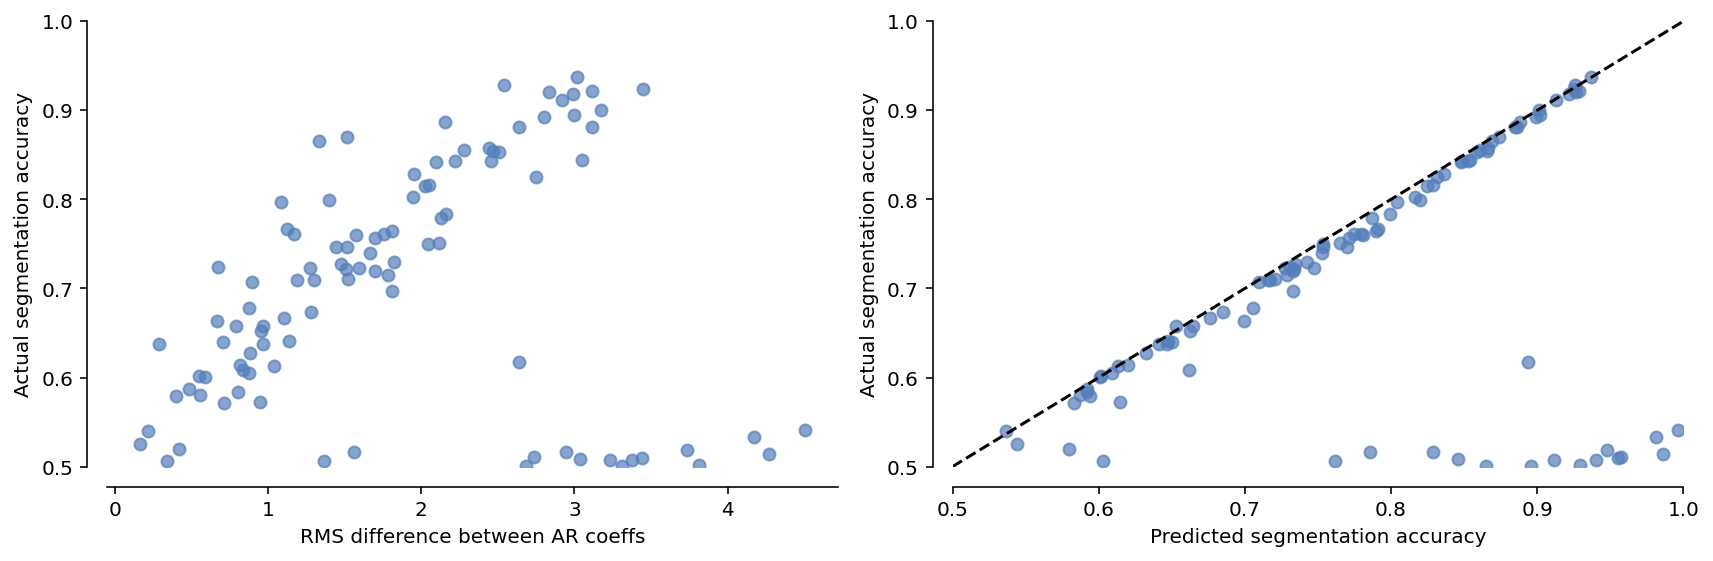

In [15]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(two_ar3.diff_arma, two_ar3.result_biowta[1].trial_scores, alpha=0.7)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("RMS difference between AR coeffs")
    ax1.set_ylabel("Actual segmentation accuracy")

    ax2.scatter(
        two_ar3.predicted_score, two_ar3.result_biowta[1].trial_scores, alpha=0.7
    )
    ax2.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax2.set_xlim(0.5, 1.0)
    ax2.set_ylim(0.5, 1.0)

    ax2.set_xlabel("Predicted segmentation accuracy")
    ax2.set_ylabel("Actual segmentation accuracy")

# fig.savefig(os.path.join(fig_path, "example_predicting_accuracy_score.pdf"))

#### Diagnose some failed runs

In [16]:
(
    (np.asarray(two_ar3.predicted_score) > 0.75)
    & (two_ar3.result_biowta[1].trial_scores < 0.6)
).nonzero()[0]

array([ 0, 16, 18, 24, 28, 36, 38, 39, 52, 54, 60, 67, 82, 90, 92])

Accuracy score in this interval: 0.62.


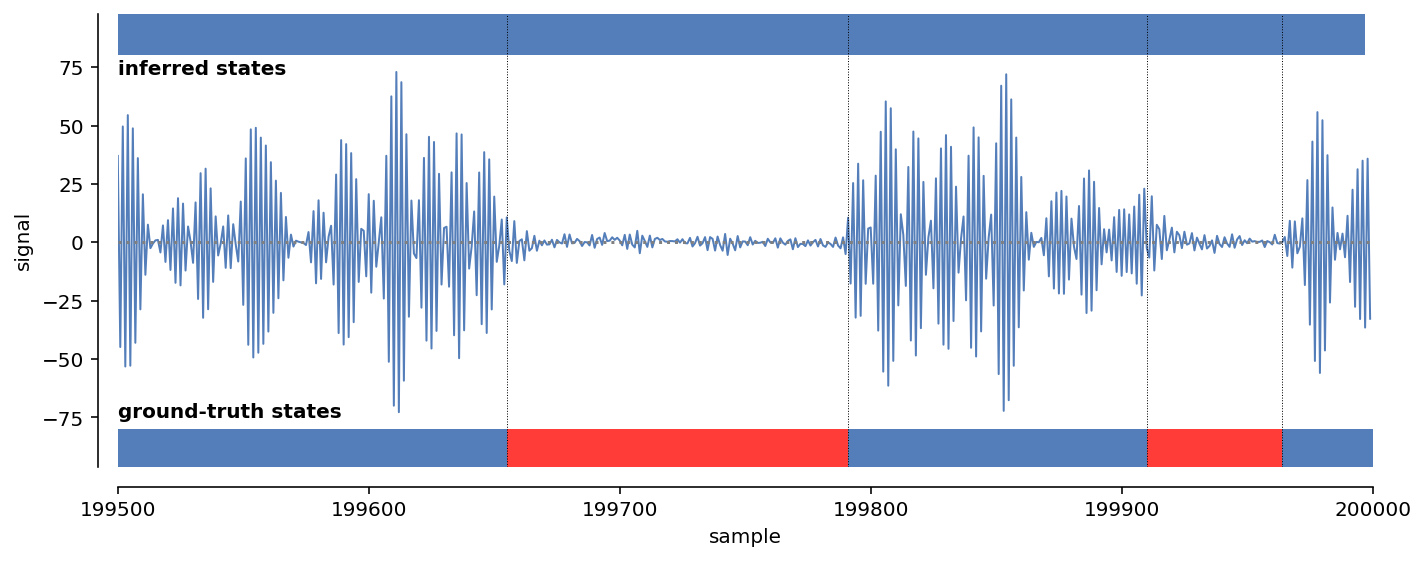

In [17]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_idx = 0
    crt_dataset = two_ar3.dataset[crt_idx]
    crt_n = len(crt_dataset.y)
    crt_range = slice(crt_n - 500, crt_n)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        crt_dataset.y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta[1].history[crt_idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

In [18]:
two_ar3.dataset.armas[crt_idx]

[Arma(a=array([-2.63852741, -2.38270964, -0.72760411]), b=array([], dtype=float64), bias=0, default_source=None),
 Arma(a=array([-0.4666004 ,  0.37290782,  0.77077278]), b=array([], dtype=float64), bias=0, default_source=None)]

In [19]:
[[np.linalg.norm(_) for _ in two_ar3.dataset.armas[crt_idx][__].calculate_poles()] for __ in range(two_ar3.n_models)]

[[0.9670464181228928, 0.9670464181228928, 0.778037448494408],
 [0.8998078596671719, 0.9255252974817826, 0.9255252974817826]]

### Plots for autocorrelation-based results

Note that the autocorrelation-based results automatically assume non-trivial streaks.

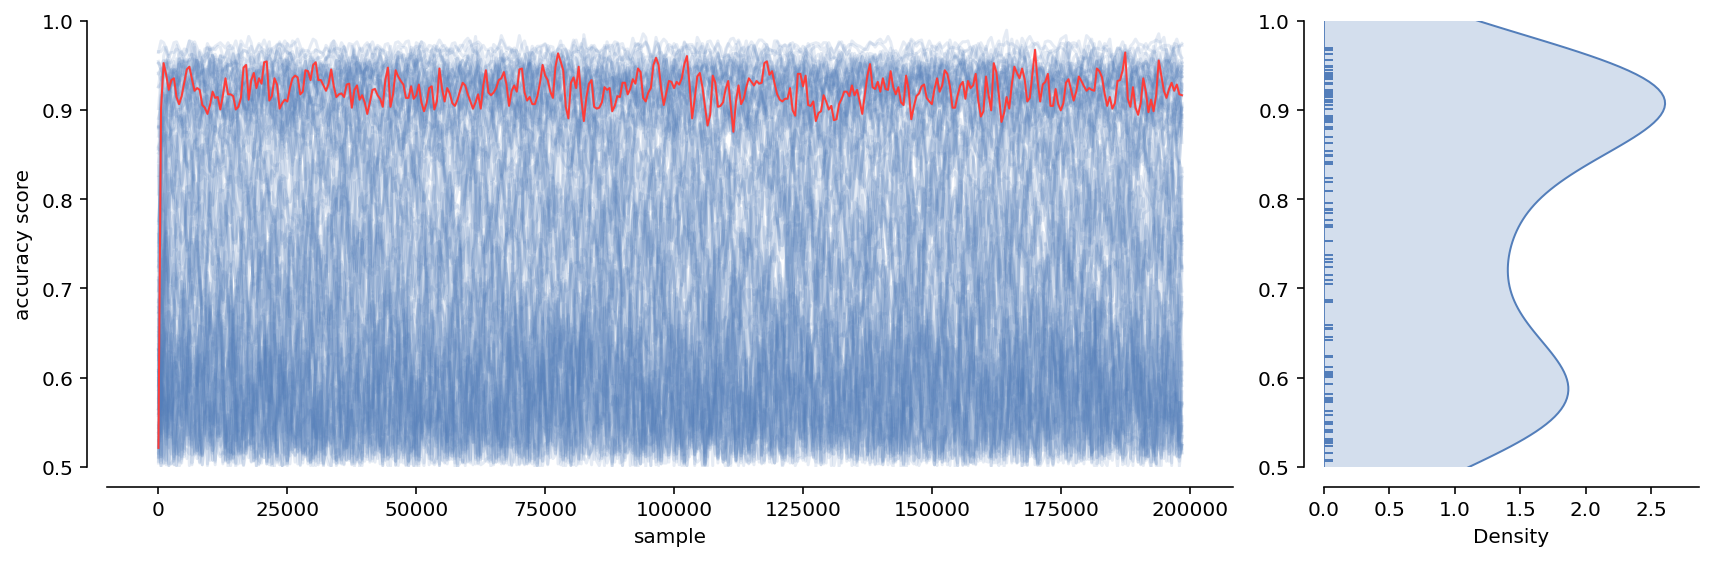

In [20]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_xcorr:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    # idx = np.argmin(np.abs(two_ar3.result_xcorr[1].trial_scores - 0.85))
    ax1.plot(*two_ar3.rolling_score_xcorr[idx], c="C1", lw=1)
    
    ax1.set_ylim(0.5, 1.0)
    
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        y=two_ar3.result_xcorr[1].trial_scores, shade=True, ax=ax2
    )
    sns.rugplot(y=two_ar3.result_xcorr[1].trial_scores, ax=ax2)
    ax2.set_ylim(0.5, 1.0)

# fig.savefig(os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_xcorr.png"), dpi=300)

Accuracy score in this interval: 0.91.


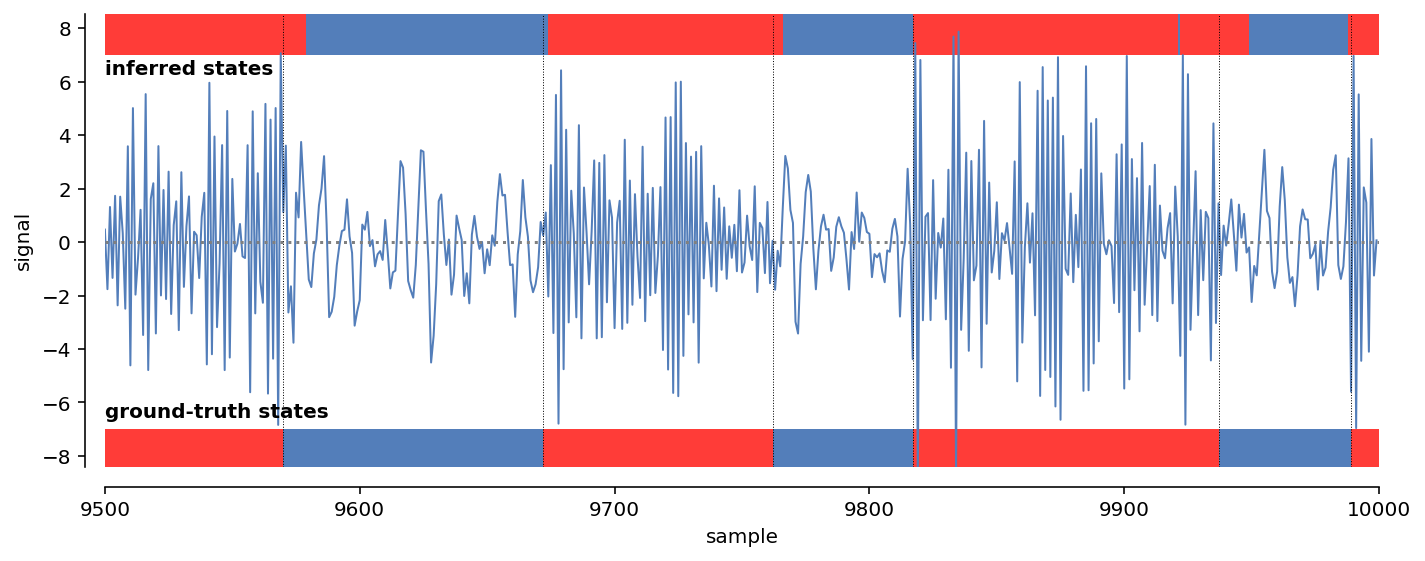

In [21]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_xcorr[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

# fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_xcorr.pdf"))

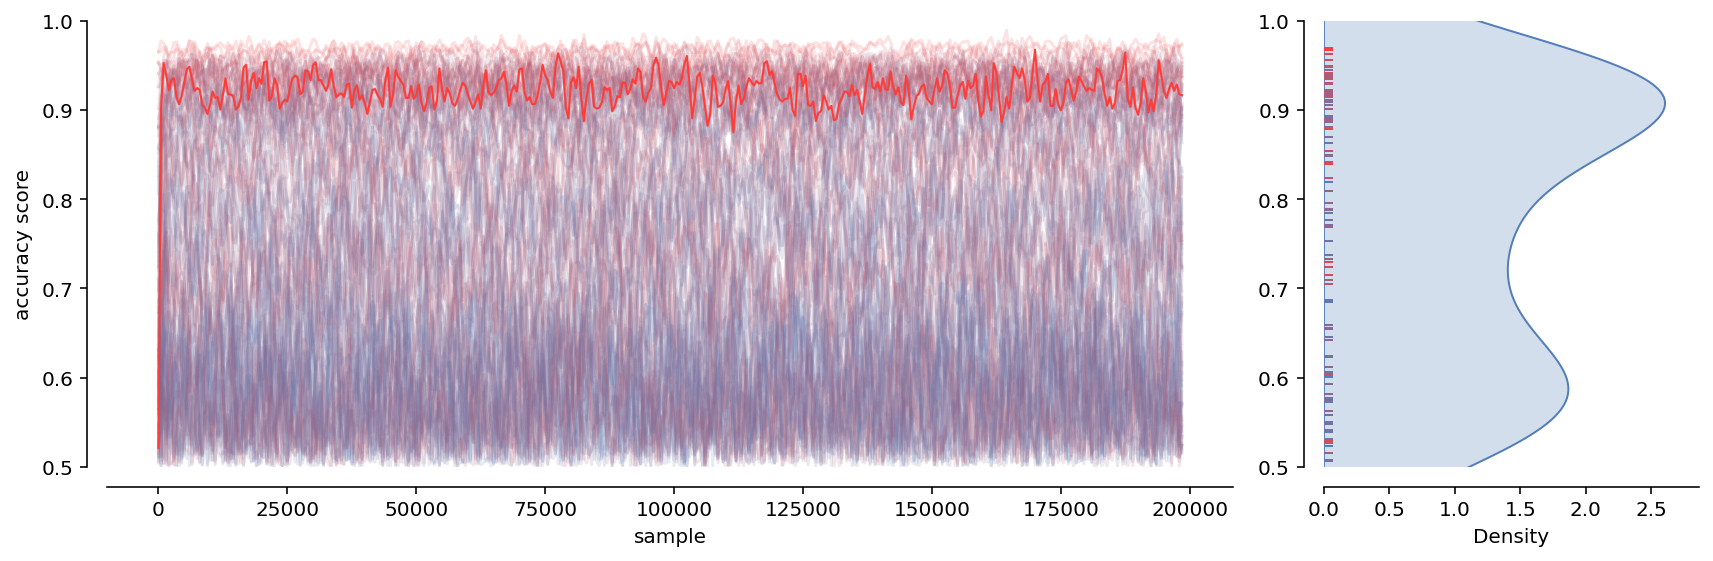

In [22]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    crt_cmap = make_gradient_cmap("C0_to_C1", "C0", "C1")
    crt_min = np.min(two_ar3.diff_arma)
    crt_max = np.max(two_ar3.diff_arma)
    crt_range = crt_max - crt_min
    for i, crt_rolling in enumerate(two_ar3.rolling_score_xcorr):
        crt_score = two_ar3.diff_arma[i]
        ax1.plot(
            *crt_rolling, c=crt_cmap((crt_score - crt_min) / crt_range), alpha=0.15
        )

    ax1.plot(*two_ar3.rolling_score_xcorr[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)
    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        y=two_ar3.result_xcorr[1].trial_scores, shade=True, ax=ax2
    )
    sns.rugplot(
        y=two_ar3.result_xcorr[1].trial_scores,
        # colors=crt_cmap((two_ar3.diff_arma - crt_min) / crt_range),
        hue=(two_ar3.diff_arma - crt_min) / crt_range,
        palette=crt_cmap,
        legend=False,
        ax=ax2,
    )
    ax2.set_ylim(0.5, 1.0)

# fig.savefig(
#     os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_xcorr_color_by_armadiff.png"),
#     dpi=300,
# )

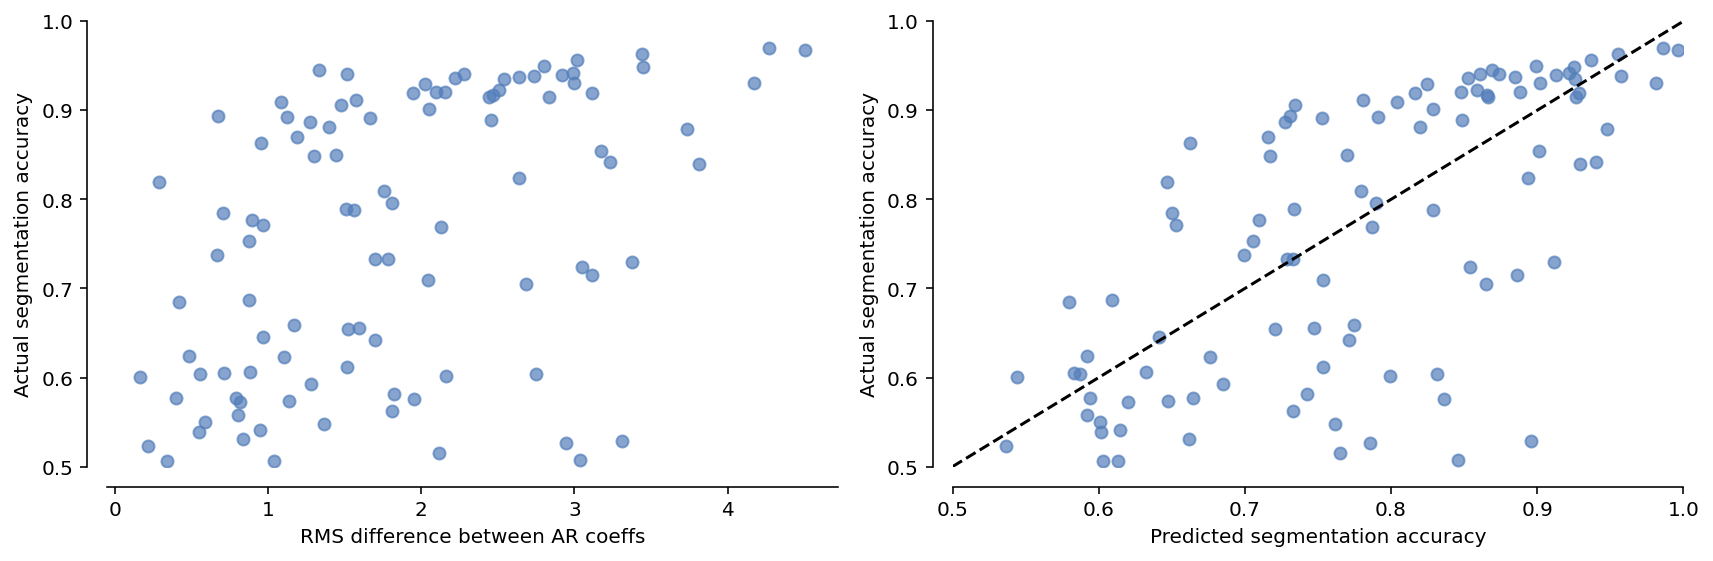

In [23]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(two_ar3.diff_arma, two_ar3.result_xcorr[1].trial_scores, alpha=0.7)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("RMS difference between AR coeffs")
    ax1.set_ylabel("Actual segmentation accuracy")

    ax2.scatter(
        two_ar3.predicted_score, two_ar3.result_xcorr[1].trial_scores, alpha=0.7
    )
    ax2.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax2.set_xlim(0.5, 1.0)
    ax2.set_ylim(0.5, 1.0)

    ax2.set_xlabel("Predicted segmentation accuracy")
    ax2.set_ylabel("Actual segmentation accuracy")

# fig.savefig(os.path.join(fig_path, "example_predicting_accuracy_score_xcorr.pdf"))

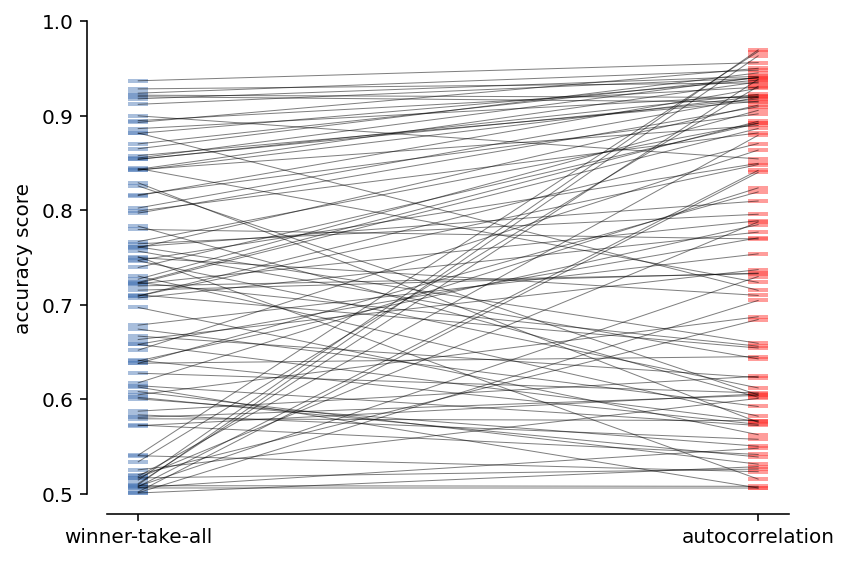

In [24]:
with FigureManager() as (fig, ax):
    crt_wta_scores = two_ar3.result_biowta[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores

    ax.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )
    ax.plot(
        np.row_stack((np.zeros(two_ar3.n_signals), np.ones(two_ar3.n_signals))),
        np.row_stack((crt_wta_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["winner-take-all", "autocorrelation"])

    ax.set_ylim(0.5, 1)

    ax.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "naive_biowta_vs_xcorr.pdf"))

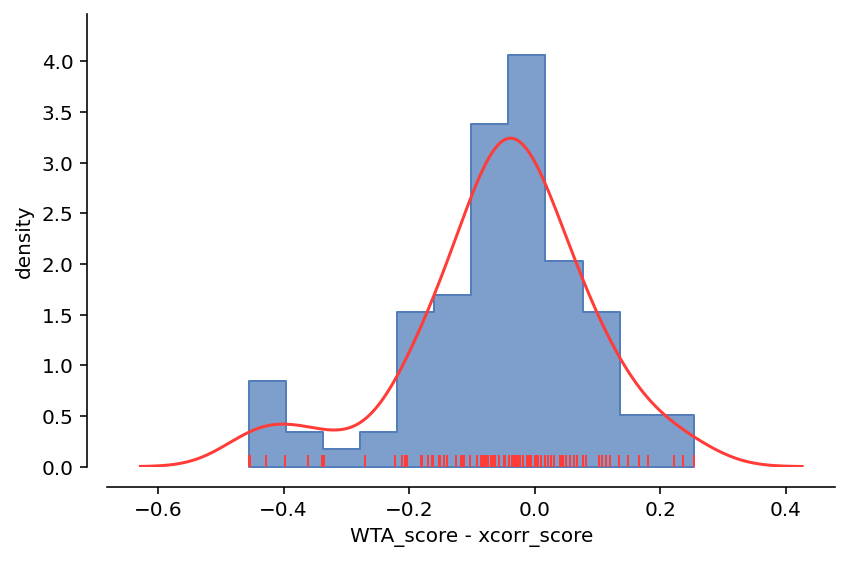

In [25]:
with FigureManager() as (_, ax):
    sns.histplot(
        two_ar3.result_biowta[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        element="step",
        stat="density",
        ax=ax,
    )
    sns.kdeplot(
        two_ar3.result_biowta[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        c="C1",
        ax=ax,
    )
    sns.rugplot(
        two_ar3.result_biowta[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        c="C1",
        ax=ax,
    )

    ax.set_xlabel("WTA_score - xcorr_score")
    ax.set_ylabel("density")

In [26]:
(
    (np.asarray(two_ar3.predicted_score) > 0.75)
    & (two_ar3.result_xcorr[1].trial_scores < 0.6)
).nonzero()[0]

array([38, 54, 64, 90, 91, 92])

Accuracy score in this interval: 0.36.


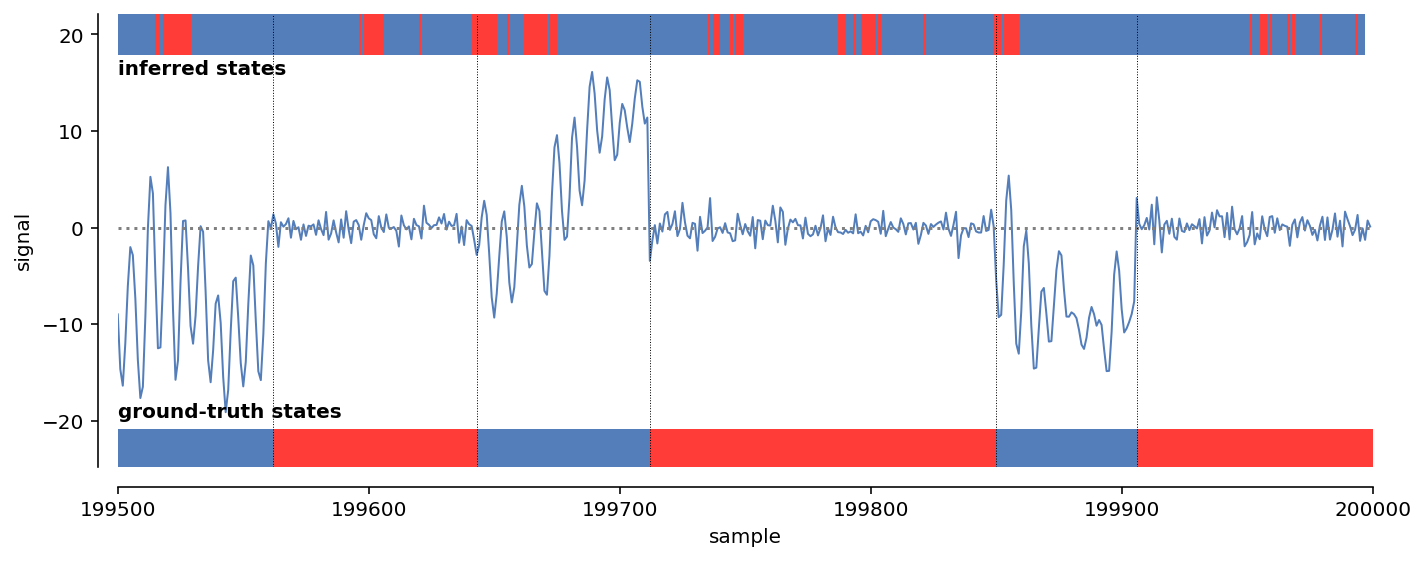

In [27]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_idx = 38
    crt_dataset = two_ar3.dataset[crt_idx]
    crt_n = len(crt_dataset.y)
    crt_range = slice(crt_n - 500, crt_n)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        crt_dataset.y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_xcorr[1].history[crt_idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

In [28]:
two_ar3.dataset.armas[crt_idx]

[Arma(a=array([ 2.17919209, -2.15435055,  0.96943361]), b=array([], dtype=float64), bias=0, default_source=None),
 Arma(a=array([-0.23082174, -0.11378922, -0.02321241]), b=array([], dtype=float64), bias=0, default_source=None)]

In [29]:
[[np.linalg.norm(_) for _ in two_ar3.dataset.armas[crt_idx][__].calculate_poles()] for __ in range(two_ar3.n_models)]

[[0.9927539941968309, 0.9881849008095943, 0.9881849008095943],
 [0.33123380172539824, 0.33123380172539824, 0.21156845572652933]]

## Run `BioWTA` with non-trivial `trans_mat`

In [30]:
t0 = time.time()
two_ar3.result_biowta_streak = hyper_score_ar(
    BioWTARegressor,
    two_ar3.dataset,
    two_ar3.metric,
    n_models=two_ar3.n_models,
    n_features=two_ar3.n_features,
    rate=two_ar3.rate_biowta,
    trans_mat=1 - 1 / two_ar3.streak_biowta,
    progress=tqdm,
    monitor=["r", "weights_", "prediction_"],
)
t1 = time.time()
print(
    f"Median accuracy score BioWTA with streak: {two_ar3.result_biowta_streak[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score BioWTA with streak: 0.8. (Took 51.74 seconds.)


In [31]:
two_ar3.rolling_score_biowta_streak = []
for i in tqdm(range(two_ar3.n_signals)):
    crt_dataset = two_ar3.dataset[i]

    crt_r_biowta = two_ar3.result_biowta_streak[1].history[i].r
    crt_inferred_biowta = np.argmax(crt_r_biowta, axis=1)

    crt_loc_biowta, crt_sliding_score_biowta = calculate_sliding_score(
        two_ar3.metric, crt_dataset.usage_seq, crt_inferred_biowta
    )
    two_ar3.rolling_score_biowta_streak.append(
        (crt_loc_biowta, crt_sliding_score_biowta)
    )

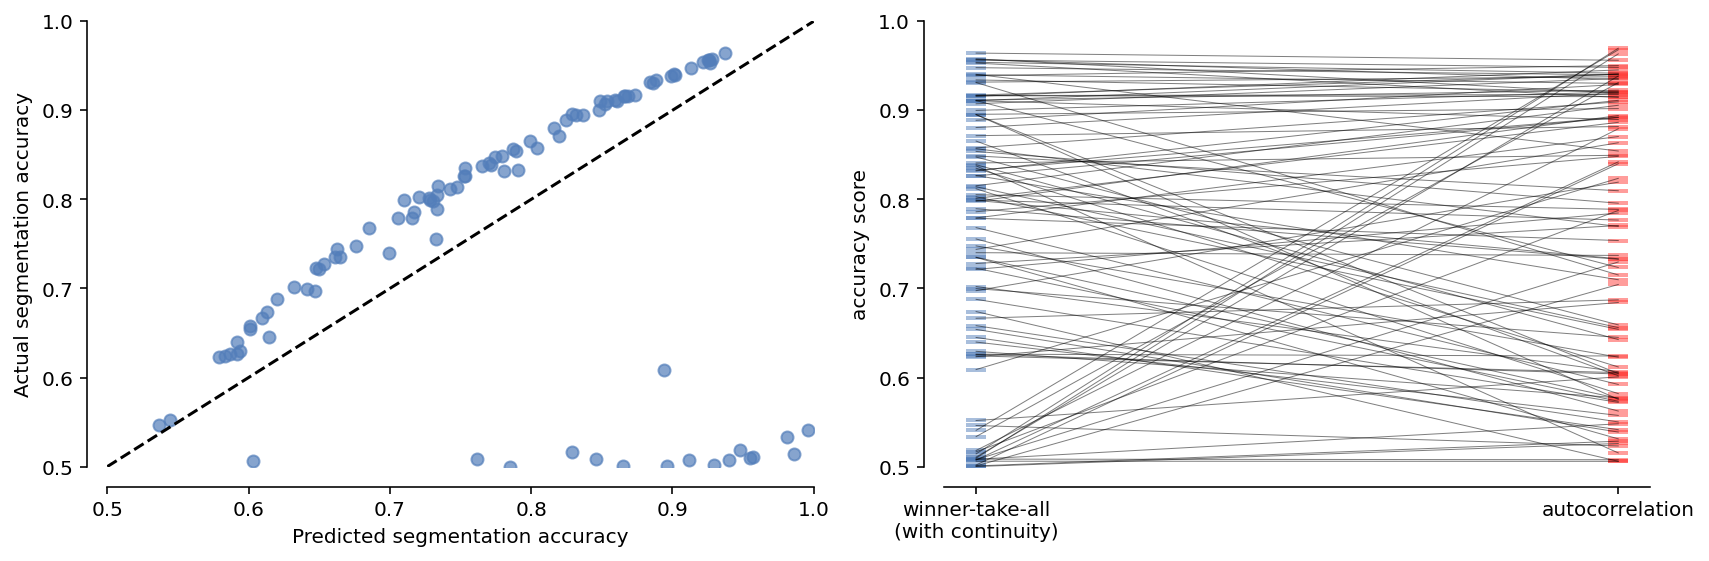

In [32]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.predicted_score, two_ar3.result_biowta_streak[1].trial_scores, alpha=0.7
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Predicted segmentation accuracy")
    ax1.set_ylabel("Actual segmentation accuracy")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )
    ax2.plot(
        np.row_stack((np.zeros(two_ar3.n_signals), np.ones(two_ar3.n_signals))),
        np.row_stack((crt_wta_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(["winner-take-all\n(with continuity)", "autocorrelation"])

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "biowta_results_with_streak.pdf"), transparent=True)

Accuracy score in this interval: 0.92.


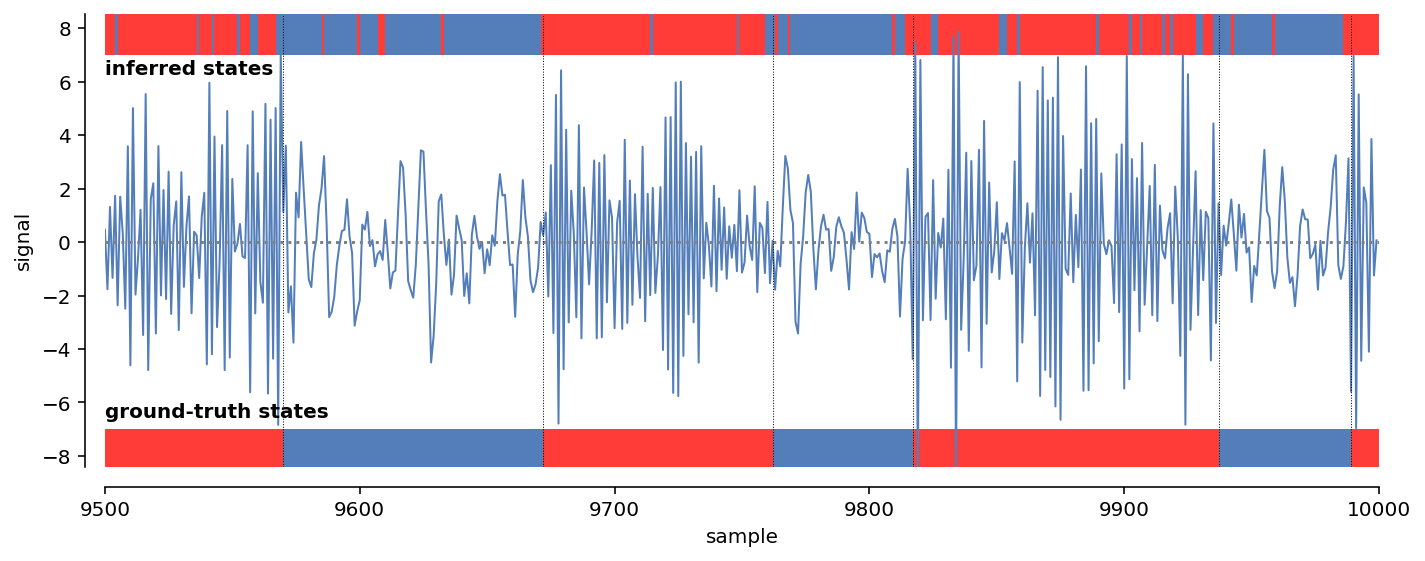

In [33]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_biowta_streak[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

# fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_biowta_streak.pdf"))

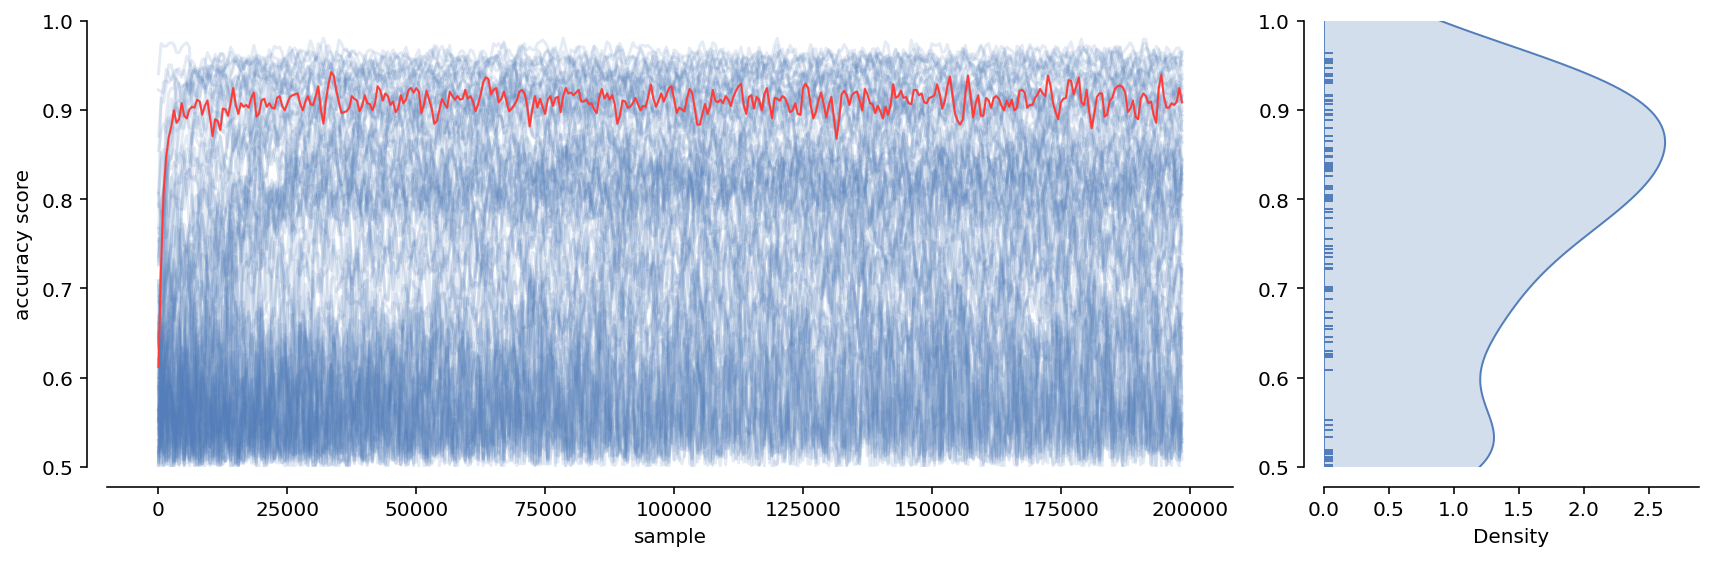

In [34]:
with FigureManager(1, 2, gridspec_kw={"width_ratios": (3, 1)}) as (
    fig,
    (ax1, ax2),
):
    for crt_rolling in two_ar3.rolling_score_biowta_streak:
        ax1.plot(*crt_rolling, c="C0", alpha=0.15)

    ax1.plot(*two_ar3.rolling_score_biowta_streak[idx], c="C1", lw=1)

    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("sample")
    ax1.set_ylabel("accuracy score")

    sns.kdeplot(
        y=two_ar3.result_biowta_streak[1].trial_scores, shade=True, ax=ax2
    )
    sns.rugplot(y=two_ar3.result_biowta_streak[1].trial_scores, ax=ax2)
    ax2.set_ylim(0.5, 1.0)

# fig.savefig(
#     os.path.join(fig_path, "rolling_accuracy_2x_ar3_100trials_biowta_streak.png"),
#     dpi=300,
# )

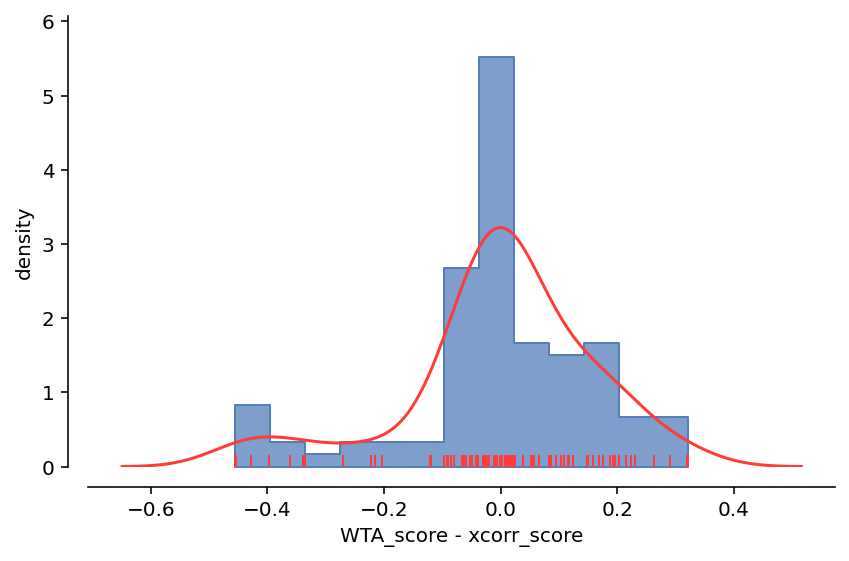

In [35]:
with FigureManager() as (_, ax):
    sns.histplot(
        two_ar3.result_biowta_streak[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        element="step",
        stat="density",
        ax=ax,
    )
    sns.kdeplot(
        two_ar3.result_biowta_streak[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        c="C1",
        ax=ax,
    )
    sns.rugplot(
        two_ar3.result_biowta_streak[1].trial_scores - two_ar3.result_xcorr[1].trial_scores,
        c="C1",
        ax=ax,
    )

    ax.set_xlabel("WTA_score - xcorr_score")
    ax.set_ylabel("density")

## Get cepstral results

In [36]:
t0 = time.time()
two_ar3.result_cepstral = hyper_score_ar(
    CepstralRegressor,
    two_ar3.dataset,
    two_ar3.metric,
    cepstral_order=two_ar3.n_features,
    cepstral_kws={"rate": two_ar3.rate_cepstral},
    initial_weights="oracle_ar",
    progress=tqdm,
    monitor=["r"],
)
t1 = time.time()
print(
    f"Median accuracy score cepstral: {two_ar3.result_cepstral[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score cepstral: 0.91. (Took 201.08 seconds.)


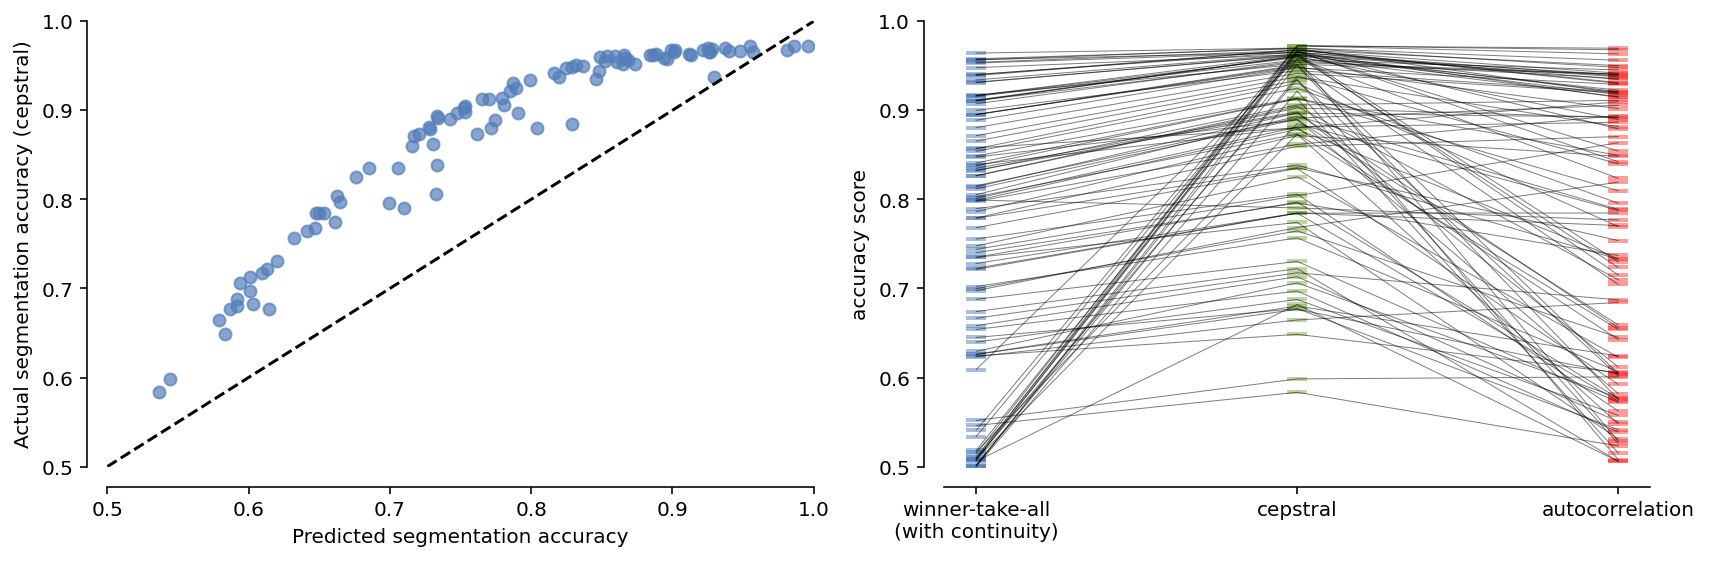

In [37]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.predicted_score, two_ar3.result_cepstral[1].trial_scores, alpha=0.7
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Predicted segmentation accuracy")
    ax1.set_ylabel("Actual segmentation accuracy (cepstral)")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores
    crt_cepstral_scores = two_ar3.result_cepstral[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        0.5 * np.ones(two_ar3.n_signals),
        crt_cepstral_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C2",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )

    ax2.plot(
        np.row_stack(
            (
                np.zeros(two_ar3.n_signals),
                0.5 * np.ones(two_ar3.n_signals),
                np.ones(two_ar3.n_signals),
            )
        ),
        np.row_stack((crt_wta_scores, crt_cepstral_scores, crt_xcorr_scores)),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks([0, 0.5, 1])
    ax2.set_xticklabels(
        ["winner-take-all\n(with continuity)", "cepstral", "autocorrelation"]
    )

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "cepstral_results_vs_xcorr_and_biowta_with_streak.pdf"), transparent=True)

## Get variance-regressor results

In [38]:
t0 = time.time()
two_ar3.result_avg_error = hyper_score_ar(
    VarianceRegressor,
    two_ar3.dataset,
    two_ar3.metric,
    variance_kws={"rate": two_ar3.rate_avg_error},
    initial_weights="oracle_ar",
    progress=tqdm,
    monitor=["r"],
)
t1 = time.time()
print(
    f"Median accuracy score average error: {two_ar3.result_avg_error[0]:.2}. "
    f"(Took {t1 - t0:.2f} seconds.)"
)


Median accuracy score average error: 0.94. (Took 14.62 seconds.)


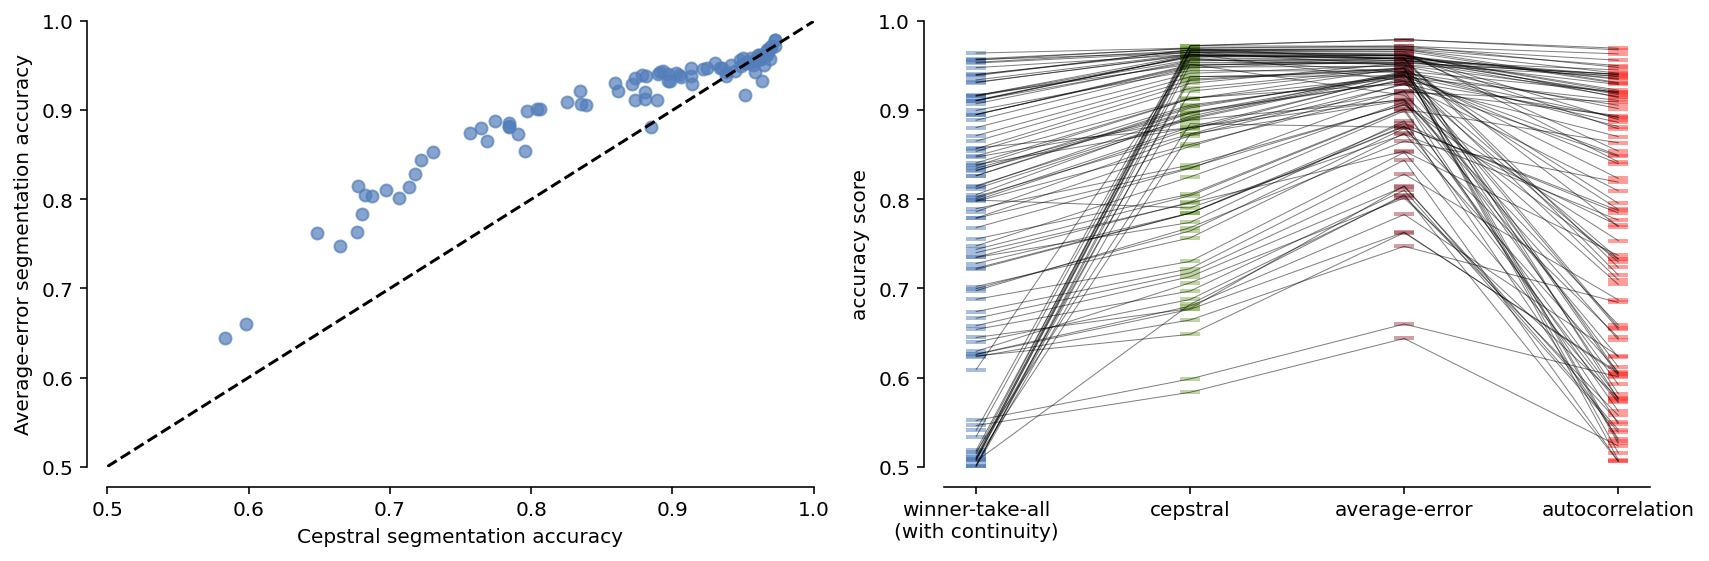

In [39]:
with FigureManager(1, 2) as (fig, (ax1, ax2)):
    ax1.scatter(
        two_ar3.result_cepstral[1].trial_scores,
        two_ar3.result_avg_error[1].trial_scores,
        alpha=0.7,
    )
    ax1.plot([0.5, 1.0], [0.5, 1.0], "k--")

    ax1.set_xlim(0.5, 1.0)
    ax1.set_ylim(0.5, 1.0)

    ax1.set_xlabel("Cepstral segmentation accuracy")
    ax1.set_ylabel("Average-error segmentation accuracy")

    crt_wta_scores = two_ar3.result_biowta_streak[1].trial_scores
    crt_xcorr_scores = two_ar3.result_xcorr[1].trial_scores
    crt_cepstral_scores = two_ar3.result_cepstral[1].trial_scores
    crt_avg_error_scores = two_ar3.result_avg_error[1].trial_scores

    ax2.plot(
        np.zeros(two_ar3.n_signals),
        crt_wta_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C0",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals) / 3,
        crt_cepstral_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C2",
        alpha=0.5,
    )
    ax2.plot(
        2 * np.ones(two_ar3.n_signals) / 3,
        crt_avg_error_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C3",
        alpha=0.5,
    )
    ax2.plot(
        np.ones(two_ar3.n_signals),
        crt_xcorr_scores,
        ls="none",
        marker="_",
        ms=10,
        mew=2,
        c="C1",
        alpha=0.5,
    )

    ax2.plot(
        np.row_stack(
            (
                np.zeros(two_ar3.n_signals),
                np.ones(two_ar3.n_signals) / 3,
                2 * np.ones(two_ar3.n_signals) / 3,
                np.ones(two_ar3.n_signals),
            )
        ),
        np.row_stack(
            (
                crt_wta_scores,
                crt_cepstral_scores,
                crt_avg_error_scores,
                crt_xcorr_scores,
            )
        ),
        "k-",
        lw=0.5,
        alpha=0.5,
    )
    ax2.set_xticks(np.arange(4) / 3)
    ax2.set_xticklabels(
        [
            "winner-take-all\n(with continuity)",
            "cepstral",
            "average-error",
            "autocorrelation",
        ]
    )

    ax2.set_ylim(0.5, 1)

    ax2.set_ylabel("accuracy score")

# fig.savefig(os.path.join(fig_path, "cepstral_results_vs_xcorr_and_biowta_with_streak.pdf"), transparent=True)

## Temporal correlations explanation

In [40]:
rng = np.random.default_rng(4)

# scales chosen so the outputs of both processes have aproximately unit variance
two_ar_short = SimpleNamespace(
    arma1=Arma(
        [-0.474], [], default_source=sources.GaussianNoise(scale=0.879, rng=rng)
    ),
    arma2=Arma([0.6], [], default_source=sources.GaussianNoise(scale=0.802, rng=rng)),
)
two_ar_short.armas = [two_ar_short.arma1, two_ar_short.arma2]

crt_samples1 = two_ar_short.arma1.transform(100000)
crt_samples2 = two_ar_short.arma2.transform(100000)

print("should be almost zero:", np.std(crt_samples1) - 1, np.std(crt_samples2) - 1)

two_ar_short.n_samples = 500
two_ar_short.usage_seq = np.zeros(two_ar_short.n_samples, dtype=int)
two_ar_short.usage_seq[150:390] = 1
two_ar_short.sig = sample_switching_models(two_ar_short.armas, two_ar_short.usage_seq)

two_ar_short.transitions = np.cumsum([_[1] for _ in rle_encode(two_ar_short.usage_seq)])

should be almost zero: -0.0017277813465631509 0.00043096358641037114


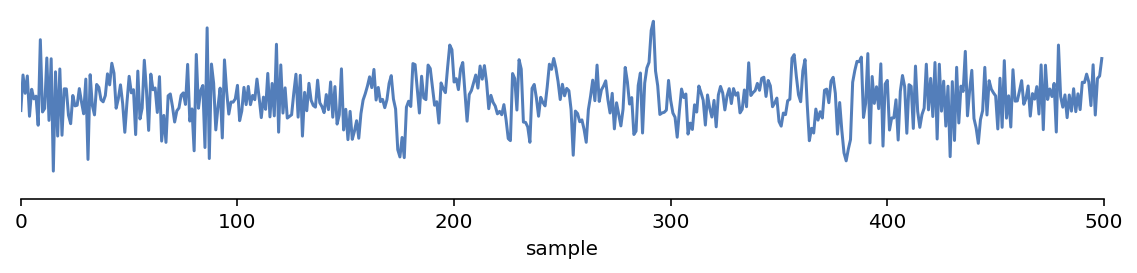

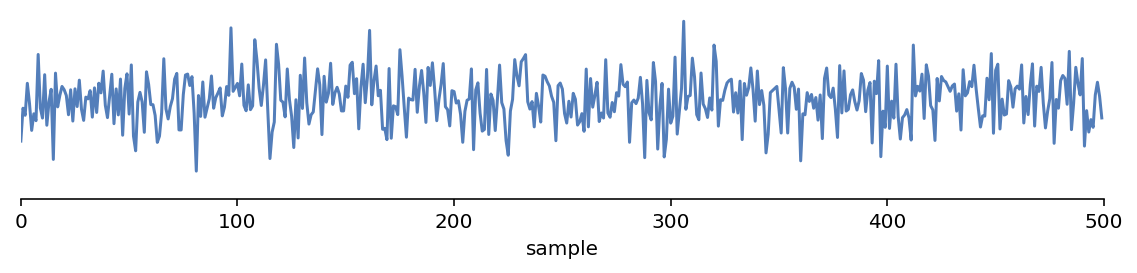

In [41]:
with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig1,
    ax1,
):
    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig2,
    ax2,
):
    crt_trans = np.hstack(([0], two_ar_short.transitions))
    shuf_sig = np.copy(two_ar_short.sig)
    rng = np.random.default_rng(1)
    for crt_t1, crt_t2 in zip(crt_trans, crt_trans[1:]):
        shuf_sig[crt_t1:crt_t2] = rng.permutation(shuf_sig[crt_t1:crt_t2])

    ax2.plot(shuf_sig)
    ax2.set_xlabel("sample")

    ax2.set_xlim(0, two_ar_short.n_samples)

    ax2.set_yticks([])

# fig1.savefig(os.path.join(fig_path, "example_switching.pdf"), transparent=True)
# fig2.savefig(os.path.join(fig_path, "example_switching_shuffled.pdf"), transparent=True)

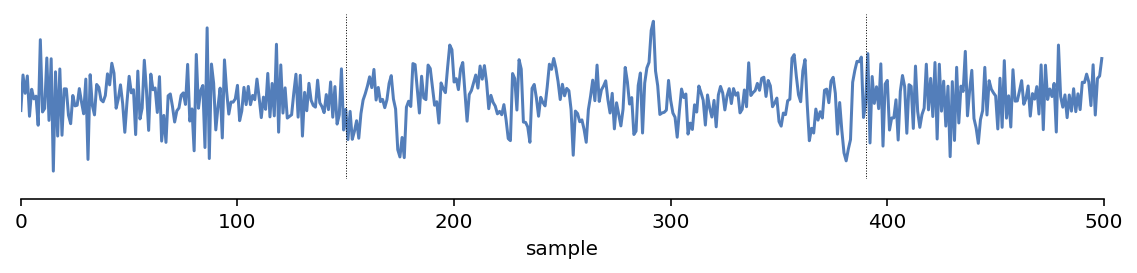

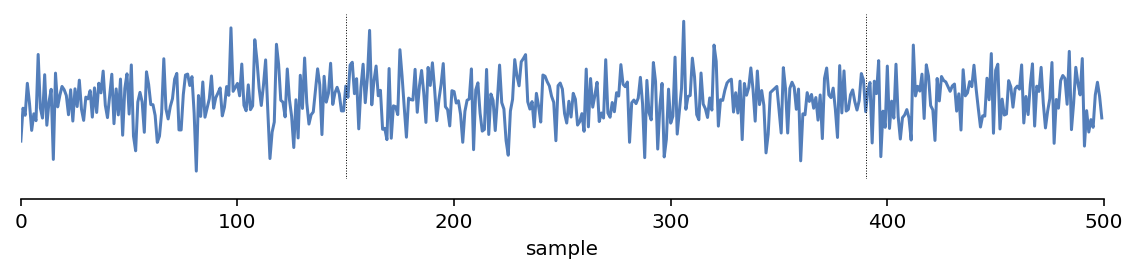

In [42]:
with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig1,
    ax1,
):
    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

    show_latent(two_ar_short.usage_seq, show_bars=False, ax=ax1)

with FigureManager(figsize=(8, 2), sharex=True, despine_kws={"left": True}) as (
    fig2,
    ax2,
):
    crt_trans = np.hstack(([0], two_ar_short.transitions))
    shuf_sig = np.copy(two_ar_short.sig)
    rng = np.random.default_rng(1)
    for crt_t1, crt_t2 in zip(crt_trans, crt_trans[1:]):
        shuf_sig[crt_t1:crt_t2] = rng.permutation(shuf_sig[crt_t1:crt_t2])

    ax2.plot(shuf_sig)
    ax2.set_xlabel("sample")

    ax2.set_xlim(0, two_ar_short.n_samples)

    show_latent(two_ar_short.usage_seq, show_bars=False, ax=ax2)

    ax2.set_yticks([])

# fig1.savefig(os.path.join(fig_path, "example_switching_vlines.pdf"), transparent=True)
# fig2.savefig(os.path.join(fig_path, "example_switching_shuffled_vlines.pdf"), transparent=True)

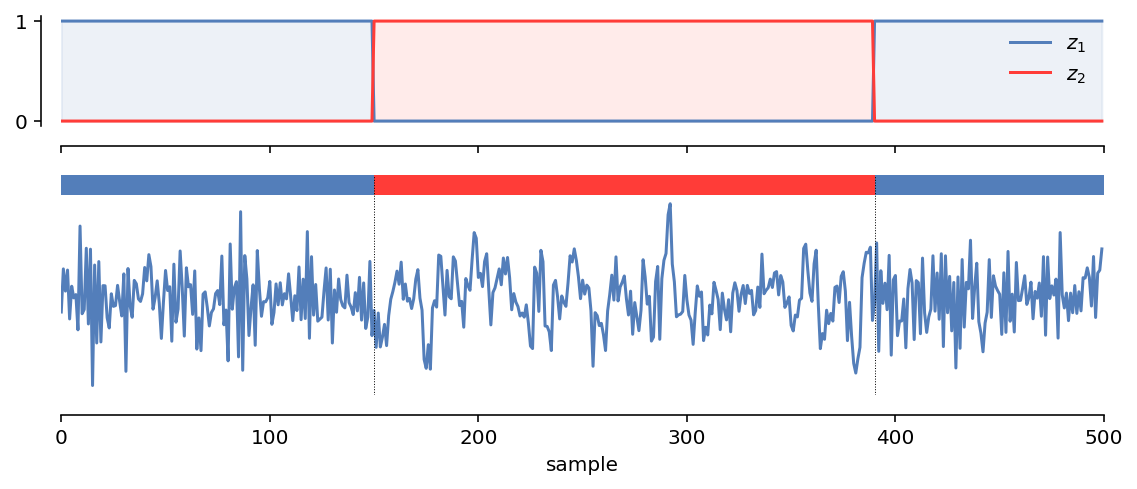

In [43]:
with FigureManager(
    2, 1, figsize=(8, 3.5), sharex=True, gridspec_kw={"height_ratios": (1, 2)}
) as (
    fig1,
    (ax0, ax1),
):
    ax0.plot(two_ar_short.usage_seq == 0, "C0", label="$z_1$")
    ax0.plot(two_ar_short.usage_seq == 1, "C1", label="$z_2$")

    ax0.fill_between(
        np.arange(two_ar_short.n_samples),
        two_ar_short.usage_seq == 0,
        color="C0",
        alpha=0.1,
    )
    ax0.fill_between(
        np.arange(two_ar_short.n_samples),
        two_ar_short.usage_seq == 1,
        color="C1",
        alpha=0.1,
    )
    ax0.legend(frameon=False)

    ax1.plot(two_ar_short.sig)
    ax1.set_xlabel("sample")

    ax1.set_xlim(0, two_ar_short.n_samples)
    ax1.set_yticks([])

    show_latent(two_ar_short.usage_seq, ax=ax1)

sns.despine(left=True, ax=ax1)
# fig1.savefig(
#     os.path.join(fig_path, "example_switching_vlines_bars.pdf"), transparent=True
# )

Accuracy score in this interval: 0.95.


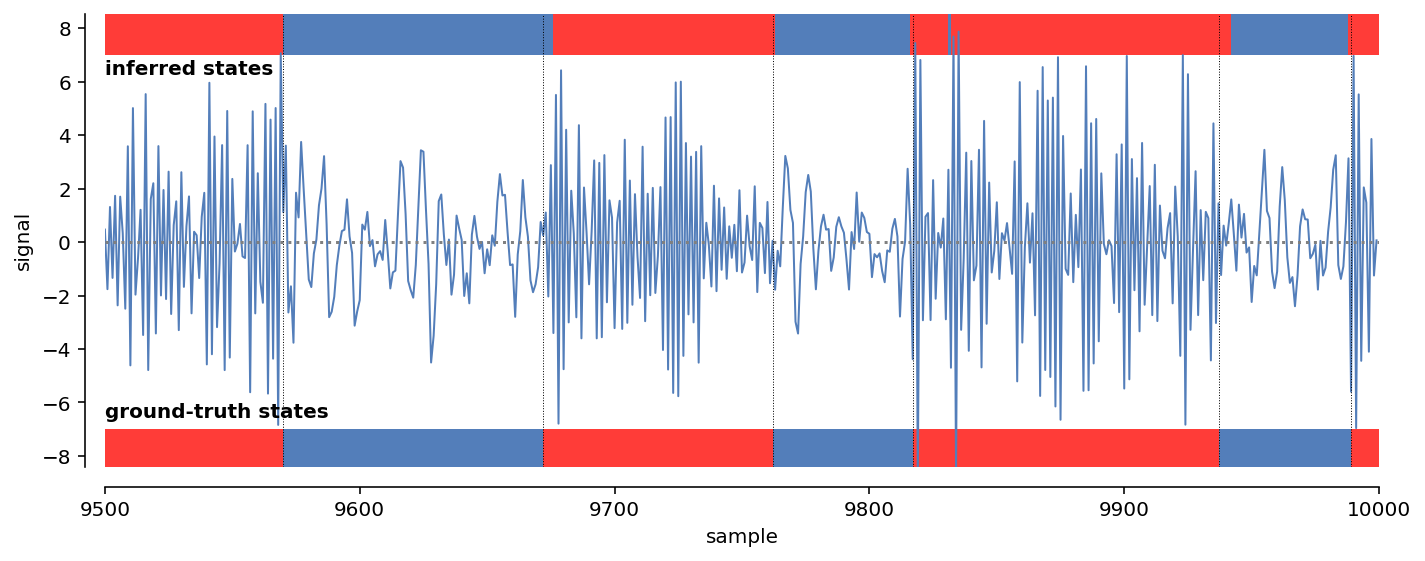

In [44]:
with FigureManager(figsize=(10, 4)) as (fig, ax):
    crt_dataset = two_ar3.dataset[idx]
    crt_n = len(crt_dataset.y)
    #  crt_range = slice(crt_n - 500, crt_n)
    crt_range = slice(9500, 10000)
    ax.plot(
        np.arange(crt_range.start, crt_range.stop),
        two_ar3.dataset[idx].y[crt_range],
        lw=1.0,
    )
    ax.axhline(0, c="gray", ls=":")
    ax.set_xlim(crt_range.start, crt_range.stop)
    ax.set_ylim(-7, 7)

    ax.set_xlabel("sample")
    ax.set_ylabel("signal")

    show_latent(crt_dataset.usage_seq, bar_location="bottom")

    crt_history = two_ar3.result_cepstral[1].history[idx]
    show_latent(np.argmax(crt_history.r, axis=1), show_vlines=False)

    ax.annotate(
        "ground-truth states",
        xy=(0, 0.1),
        xycoords="axes fraction",
        verticalalignment="bottom",
        fontweight="bold",
    )
    ax.annotate(
        "inferred states",
        xy=(0, 0.9),
        xycoords="axes fraction",
        verticalalignment="top",
        fontweight="bold",
    )

crt_mean = np.mean(
    crt_dataset.usage_seq[
        crt_range.start + two_ar3.n_features : crt_range.stop + two_ar3.n_features
    ]
    == np.argmax(crt_history.r, axis=1)[crt_range]
)
print(f"Accuracy score in this interval: {crt_mean:.2f}.")

# fig.savefig(os.path.join(fig_path, "example_2x_ar3_short_cepstral.pdf"))